## Figure 3

SV distribution in the genome

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

from scipy.stats import ks_2samp

def perform_ks_test(data1, data2):
    """
    Performs KS test for variant density comparison between two datasets.
    
    Parameters:
        data1 (pd.DataFrame): First dataset with variant positions.
        data2 (pd.DataFrame): Second dataset with variant positions.
    """
    print("Kolmogorov-Smirnov Test Results:")
    for chrom in sorted(set(data1["Chromosome"]).intersection(set(data2["Chromosome"]))):
        loc1 = data1.loc[data1["Chromosome"] == chrom, "Locus"]
        loc2 = data2.loc[data2["Chromosome"] == chrom, "Locus"]
        
        if len(loc1) > 0 and len(loc2) > 0:
            stat, p_value = ks_2samp(loc1, loc2)
            print(f"Chromosome {chrom}: KS Statistic = {stat:.4f}, p-value = {p_value:.4e}")
        else:
            print(f"Chromosome {chrom}: Insufficient data for KS test")

def parse_vcf(file_path):
    """
    Parses a VCF file to extract variants while excluding SVs smaller than 30.
    
    Parameters:
        file_path (str): Path to the VCF file.
    
    Returns:
        pd.DataFrame: DataFrame with 'Chromosome' and 'Locus' columns for valid SVs.
    """
    variants = []
    with open(file_path, 'r') as file:
        for line in file:
            if not line.startswith("#"):  # Skip header lines
                columns = line.strip().split("\t")
                chromosome = columns[0]
                locus = int(columns[1])
                info = columns[7]  # INFO field, assuming standard VCF format
                
                # Extract SV size from INFO field
                sv_size = None
                for entry in info.split(";"):
                    if entry.startswith("SVLEN="):
                        sv_size = abs(int(entry.split("=")[1]))  # Use absolute size
                        break
                
                # Include only if locus > 0 and SV size >= 30
                if locus > 0 and (sv_size is None or sv_size >= 30):
                    variants.append((chromosome, locus))
    
    return pd.DataFrame(variants, columns=["Chromosome", "Locus"])


def parse_custom(file_path):
    data = pd.read_csv(file_path)
    data = data[data["Locus"] > 0]  # Remove negative or zero loci
    return data[["Chromosome", "Locus"]]

def plot_variant_density_panels(file1, type1, label1, file2=None, type2=None, label2=None, output_pdf=None, bw_adjust=0.3):
    """
    Generates density plots for variant distributions by chromosome.
    
    Parameters:
        file1 (str): Path to the first file.
        type1 (str): Type of the first file ('vcf' or 'csv').
        label1 (str): Label for the first dataset.
        file2 (str): Path to the second file (optional).
        type2 (str): Type of the second file ('vcf' or 'csv', optional).
        label2 (str): Label for the second dataset (optional).
        output_pdf (str): Path to save the output PDF (optional).
        bw_adjust (float): Bandwidth adjustment for KDE smoothing.
    """
    # Chromosome lengths for *C. elegans* (approximate)
    chromosome_lengths = {
        "I": 15072434,
        "II": 15279421,
        "III": 13783801,
        "IV": 17493829,
        "V": 20924149,
        "X": 17718942
    }

    # Parse the first file
    if type1 == "vcf":
        data1 = parse_vcf(file1)
    else:
        data1 = parse_custom(file1)
    data1["Dataset"] = label1  # Add a dataset column

    # Parse the second file if provided
    if file2:
        if type2 == "vcf":
            data2 = parse_vcf(file2)
        else:
            data2 = parse_custom(file2)
        data2["Dataset"] = label2  # Add a dataset column
        combined_data = pd.concat([data1, data2], ignore_index=True)
    else:
        combined_data = data1

    # Filter loci within chromosome bounds and exclude mtDNA
    valid_data = combined_data[
        combined_data.apply(
            lambda row: row["Chromosome"] in chromosome_lengths 
                        and row["Locus"] <= chromosome_lengths.get(row["Chromosome"], float("inf")), 
            axis=1
        )
    ]

    # Arrange chromosomes in the desired order
    valid_data["Chromosome"] = pd.Categorical(
        valid_data["Chromosome"], 
        categories=["I", "II", "III", "IV", "V", "X"], 
        ordered=True
    )
    valid_data = valid_data.sort_values("Chromosome")

    # Configure plot aesthetics
    sns.set_theme(style="whitegrid", context="talk")

    # Create FacetGrid
    g = sns.FacetGrid(
        valid_data,
        col="Chromosome",
        hue="Dataset",
        col_wrap=2,  # Layout for 2 columns per row
        sharey=False,
        sharex=False,
        height=4,
        aspect=1.5
    )

    # Plot KDEs
    g.map(sns.kdeplot, "Locus", fill=True, alpha=0.5, bw_adjust=bw_adjust)

    # Set x-axis limits based on chromosome lengths
    for ax, chromosome in zip(g.axes.flat, valid_data["Chromosome"].cat.categories):
        ax.set_xlim(0, chromosome_lengths.get(chromosome, 1))

    # Add axis labels, titles, and legend
    g.set_axis_labels("Chromosomal Location (Locus)", "Density")
    g.set_titles("Chromosome {col_name}")
    g.add_legend(title="Dataset", loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=2)

    # Adjust layout and title
    g.fig.suptitle("Variant Density by Chromosome", fontsize=18)
    g.fig.tight_layout(rect=[0, 0, 1, 0.9])  # Leave space for the title and legend

    # Save the plot if output path is provided
    if output_pdf:
        g.savefig(output_pdf, dpi=300, format="pdf")
        print(f"Plot saved as {output_pdf}.")

    plt.show()
    
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# def plot_variant_density_panels_alternate(file1, type1, label1, file2=None, type2=None, label2=None, output_pdf=None, bw_adjust=0.3, threshold=500):
#     """
#     Generates hybrid density plots for variant distributions by chromosome.
#     Uses KDE for datasets with sufficient variants and vlines for smaller datasets.
    
#     Parameters:
#         file1 (str): Path to the first file.
#         type1 (str): Type of the first file ('vcf' or 'csv').
#         label1 (str): Label for the first dataset.
#         file2 (str): Path to the second file (optional).
#         type2 (str): Type of the second file ('vcf' or 'csv', optional).
#         label2 (str): Label for the second dataset (optional).
#         output_pdf (str): Path to save the output PDF (optional).
#         bw_adjust (float): Bandwidth adjustment for KDE smoothing.
#         threshold (int): Minimum number of variants needed to use KDE; otherwise, uses vlines.
#     """
#     chromosome_lengths = {
#         "I": 15072434, "II": 15279421, "III": 13783801,
#         "IV": 17493829, "V": 20924149, "X": 17718942
#     }

#     # Parse files
#     data1 = parse_vcf(file1) if type1 == "vcf" else parse_custom(file1)
#     data1["Dataset"] = label1
    
#     if file2:
#         data2 = parse_vcf(file2) if type2 == "vcf" else parse_custom(file2)
#         data2["Dataset"] = label2
#         combined_data = pd.concat([data1, data2], ignore_index=True)
#     else:
#         combined_data = data1

#     # Filter valid loci
#     valid_data = combined_data[
#         combined_data.apply(lambda row: row["Chromosome"] in chromosome_lengths and row["Locus"] <= chromosome_lengths[row["Chromosome"]], axis=1)
#     ]

#     # Sort chromosomes
#     valid_data["Chromosome"] = pd.Categorical(valid_data["Chromosome"], categories=["I", "II", "III", "IV", "V", "X"], ordered=True)
#     valid_data = valid_data.sort_values(["Chromosome", "Locus"])

#     # Assign colors explicitly
#     dataset_colors = dict(zip(valid_data["Dataset"].unique(), sns.color_palette("tab10", n_colors=valid_data["Dataset"].nunique())))

#     # Plot setup
#     sns.set_theme(style="whitegrid", context="talk")
#     g = sns.FacetGrid(valid_data, col="Chromosome", hue="Dataset", palette=dataset_colors, col_wrap=2, sharey=False, sharex=False, height=4, aspect=1.5)

#     # === First Pass: Plot KDE for datasets meeting threshold ===
#     for ax, (chrom, chrom_data) in zip(g.axes.flat, valid_data.groupby("Chromosome")):
#         for dataset, dataset_data in chrom_data.groupby("Dataset"):
#             if len(dataset_data) >= threshold:
#                 sns.kdeplot(dataset_data["Locus"], ax=ax, fill=True, alpha=0.5, bw_adjust=bw_adjust, label=dataset, color=dataset_colors[dataset])

#     # === Second Pass: Plot VLines for datasets below threshold ===
#     for ax, (chrom, chrom_data) in zip(g.axes.flat, valid_data.groupby("Chromosome")):
#         for dataset, dataset_data in chrom_data.groupby("Dataset"):
#             if len(dataset_data) < threshold:
#                 ax.vlines(dataset_data["Locus"], ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1] * 1, 
#                           color="red", alpha=0.7, label=dataset)

#         ax.set_xlim(0, chromosome_lengths[chrom])
#         ax.set_title(f"Chromosome {chrom}")

#     # Labels and legend
#     g.set_axis_labels("Chromosomal Location (Locus)", "Density")
#     g.add_legend(title="Dataset", loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=2)
#     g.fig.suptitle("Variant Density by Chromosome", fontsize=18)
#     g.fig.tight_layout(rect=[0, 0, 1, 0.9])

#     # Save plot
#     if output_pdf:
#         g.savefig(output_pdf, dpi=300, format="pdf")
#         print(f"Plot saved as {output_pdf}.")

#     plt.show()


def plot_variant_density_panels_alternate_2(file1, type1, label1, file2=None, type2=None, label2=None, output_pdf=None, bw_adjust=0.3, threshold=500):
    """
    Generates hybrid density plots for variant distributions by chromosome.
    Uses KDE for datasets with sufficient variants and vlines for smaller datasets.
    
    Parameters:
        file1 (str): Path to the first file.
        type1 (str): Type of the first file ('vcf' or 'csv').
        label1 (str): Label for the first dataset.
        file2 (str): Path to the second file (optional).
        type2 (str): Type of the second file ('vcf' or 'csv', optional).
        label2 (str): Label for the second dataset (optional).
        output_pdf (str): Path to save the output PDF (optional).
        bw_adjust (float): Bandwidth adjustment for KDE smoothing.
        threshold (int): Minimum number of variants needed to use KDE; otherwise, uses vlines.
    """
    chromosome_lengths = {
        "I": 15072434, "II": 15279421, "III": 13783801,
        "IV": 17493829, "V": 20924149, "X": 17718942
    }

    # Parse files
    data1 = parse_vcf(file1) if type1 == "vcf" else parse_custom(file1)
    data1["Dataset"] = label1
    
    if file2:
        data2 = parse_vcf(file2) if type2 == "vcf" else parse_custom(file2)
        data2["Dataset"] = label2
        combined_data = pd.concat([data1, data2], ignore_index=True)
        perform_ks_test(data1, data2)
    else:
        combined_data = data1

    # Filter valid loci
    valid_data = combined_data[
        combined_data.apply(lambda row: row["Chromosome"] in chromosome_lengths and row["Locus"] <= chromosome_lengths[row["Chromosome"]], axis=1)
    ]

    # Sort chromosomes
    valid_data["Chromosome"] = pd.Categorical(valid_data["Chromosome"], categories=["I", "II", "III", "IV", "V", "X"], ordered=True)
    valid_data = valid_data.sort_values(["Chromosome", "Locus"])

    # Assign colors explicitly
#     dataset_colors = dict(zip(valid_data["Dataset"].unique(), sns.color_palette("tab10", n_colors=valid_data["Dataset"].nunique())))
#     # dataset_colors.update({'MA': (1.0, 0.0, 0.0)})  # Ensure MA is red

    dataset_colors = {'WI': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765), 'MA': (0.0, 0.0, 0.0)}

    # Plot setup
    sns.set_theme(style="dark", context="talk")
    g = sns.FacetGrid(valid_data, col="Chromosome", hue="Dataset", palette=dataset_colors, col_wrap=2, sharey=False, sharex=False, height=4, aspect=1.5)

    # Store legend handles
    legend_handles = {}

    # === First Pass: Plot KDE for datasets meeting threshold ===
    for ax, (chrom, chrom_data) in zip(g.axes.flat, valid_data.groupby("Chromosome")):
        for dataset, dataset_data in chrom_data.groupby("Dataset"):
            if len(dataset_data) >= threshold:
                kde = sns.kdeplot(dataset_data["Locus"], ax=ax, fill=True, alpha=0.5, bw_adjust=bw_adjust, label=dataset, color=dataset_colors[dataset])
                # Store legend handle for KDE
                legend_handles[dataset] = mpatches.Patch(color=dataset_colors[dataset], label=f"{dataset} (Density)")

    # === Second Pass: Plot VLines for datasets below threshold ===
    for ax, (chrom, chrom_data) in zip(g.axes.flat, valid_data.groupby("Chromosome")):
        for dataset, dataset_data in chrom_data.groupby("Dataset"):
            if len(dataset_data) < threshold:
                ax.vlines(dataset_data["Locus"], ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1] * 1, 
                          color=dataset_colors[dataset], alpha=0.5, label=dataset)
                # Store legend handle for VLines
                legend_handles[f"{dataset}_vlines"] = mlines.Line2D([], [], color=dataset_colors[dataset], linestyle='-', label=f"{dataset} (VLines)")

        ax.set_xlim(0, chromosome_lengths[chrom])
        ax.set_title(f"Chromosome {chrom}")

    # Labels and custom legend
    g.set_axis_labels("Chromosomal Location (Locus)", "Density")

    # Create the final legend using collected handles
    g.fig.legend(handles=list(legend_handles.values()), loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=2, title="Dataset")

    g.fig.suptitle("Variant Density by Chromosome", fontsize=18)
    g.fig.tight_layout(rect=[0, 0, 1, 0.9])

    # Save plot
    if output_pdf:
        g.savefig(output_pdf, dpi=300, format="pdf", bbox_inches="tight", width = 8.27, height = 3.5, units = "in")
        print(f"Plot saved as {output_pdf}.")

    plt.show()



/Users/ayush/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Kolmogorov-Smirnov Test Results:
Chromosome I: KS Statistic = 0.2141, p-value = 8.9642e-01
Chromosome II: KS Statistic = 0.2022, p-value = 9.2748e-01
Chromosome III: KS Statistic = 0.2236, p-value = 8.0716e-01
Chromosome IV: KS Statistic = 0.2945, p-value = 5.7959e-01
Chromosome V: KS Statistic = 0.3742, p-value = 2.9300e-01
Chromosome X: KS Statistic = 0.1816, p-value = 8.8007e-01


/var/folders/qy/mmb9p1xn6q1_mkbh0n4lmq4r0000gn/T/ipykernel_62479/2397715924.py:284: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data["Chromosome"] = pd.Categorical(valid_data["Chromosome"], categories=["I", "II", "III", "IV", "V", "X"], ordered=True)


Plot saved as distribution_of_sv_in_genome.pdf.


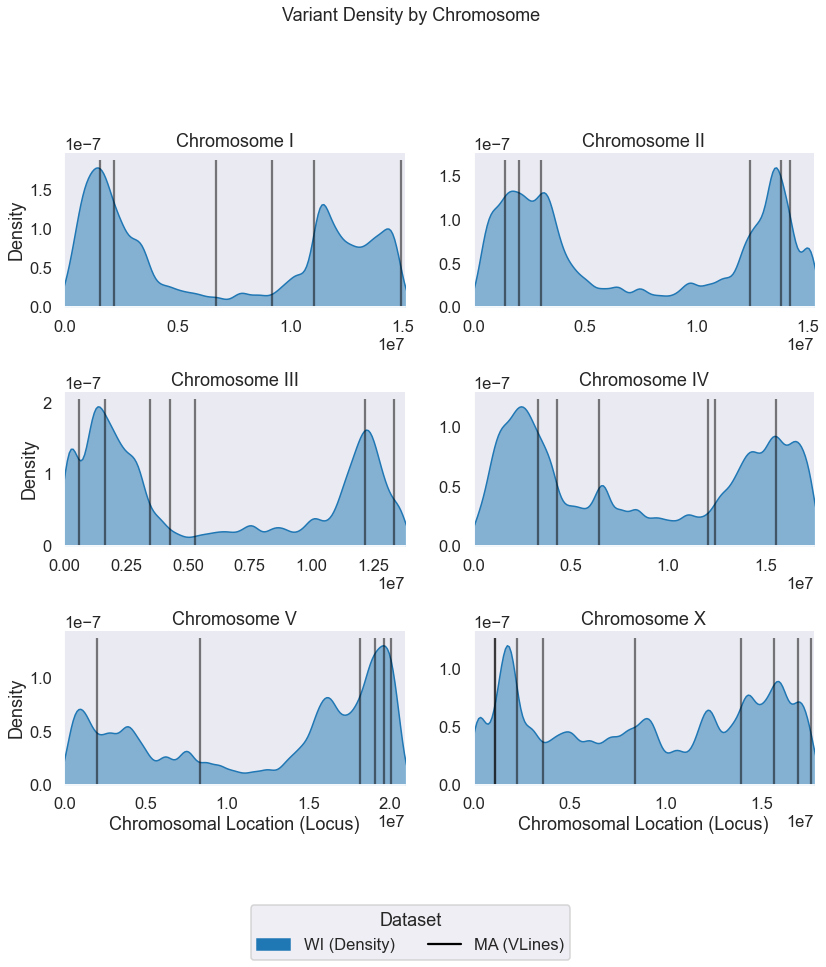

In [2]:
n2_sv = "/Users/ayush/Desktop/remapped_eicher_bams/illumina_bam_files/N2_Pass_mutations.csv"
pb_sv = "/Users/ayush/Desktop/remapped_eicher_bams/illumina_bam_files/PB_Pass_mutations.csv"
wild_isolates = "/Users/ayush/Desktop/remapped_eicher_bams/wild_joint.vcf"
ma_sv = "/Users/ayush/Desktop/remapped_eicher_bams/illumina_bam_files/N2_PB_Pass_mutations.csv"

#plot_variant_density_panels(
# plot_variant_density_panels_alternate(
#     file1=ma_sv, 
#     type1="custom", 
#     label1="MA",
#     file2=wild_isolates, 
#     type2="vcf", 
#     label2="WI",
#     output_pdf = "distribution_of_sv_in_genome.pdf"
# )

plot_variant_density_panels_alternate_2(
    file1=wild_isolates, 
    type1="vcf", 
    label1="WI",
    file2=ma_sv, 
    type2="custom", 
    label2="MA",
    output_pdf = "distribution_of_sv_in_genome.pdf"
)

